<a href="https://colab.research.google.com/github/Jenny0229/PiazzaPost_Classification/blob/main/BinaryClassification_StuIns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from sklearn.utils import resample

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


main goal: train the classifier on w16_projects_exam.csv and sp16.projects.exam.csv(about 3k samples) to predict exam and project tag;  train on w14-f15 instructor_student_csv and w16 instructor_student_csv(~14k example) for instructor/student tag

In [ ]:
file_path1 = "https://raw.githubusercontent.com/Jenny0229/PiazzaPost_Classification/main/w14-f15_instructor_student.csv?token=GHSAT0AAAAAACEAZTCIEYM2XQAEW36F6PMMZF7IEIA"
file1 = pd.read_csv(file_path1)
file_path2 = "https://raw.githubusercontent.com/Jenny0229/PiazzaPost_Classification/main/w16_instructor_student.csv?token=GHSAT0AAAAAACEAZTCIICRSFDAXW4DX2BSGZF7IE7A"
file2 = pd.read_csv(file_path2)

NameError: ignored

In [ ]:
posts = pd.DataFrame()
posts = pd.concat([posts, file1], axis=0)
posts = pd.concat([posts, file2], axis=0)
posts.to_csv('merged_files.csv', index=False)


below is the EDA phase

In [ ]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14353 entries, 0 to 2987
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tag      14353 non-null  object
 1   content  14242 non-null  object
dtypes: object(2)
memory usage: 336.4+ KB


In [ ]:
posts.head()

,tag,content
0,instructor,project lab and exam grades are posted on ctoo...
1,instructor,project 2 students submitting 557 students wpe...
2,instructor,the resources found here cover many of the ess...
3,instructor,a quick message from vidal james p james j we ...
4,instructor,hi class if you stuck around until the veeeery...


In [ ]:
#posts = posts.dropna()
posts["content"].fillna("", inplace = True)

In [ ]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14353 entries, 0 to 2987
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tag      14353 non-null  object
 1   content  14353 non-null  object
dtypes: object(2)
memory usage: 336.4+ KB


fill the posts with contents being null as empty strings

In [ ]:
posts["tag"].value_counts()

student       13940
instructor      413
Name: tag, dtype: int64

<Axes: >

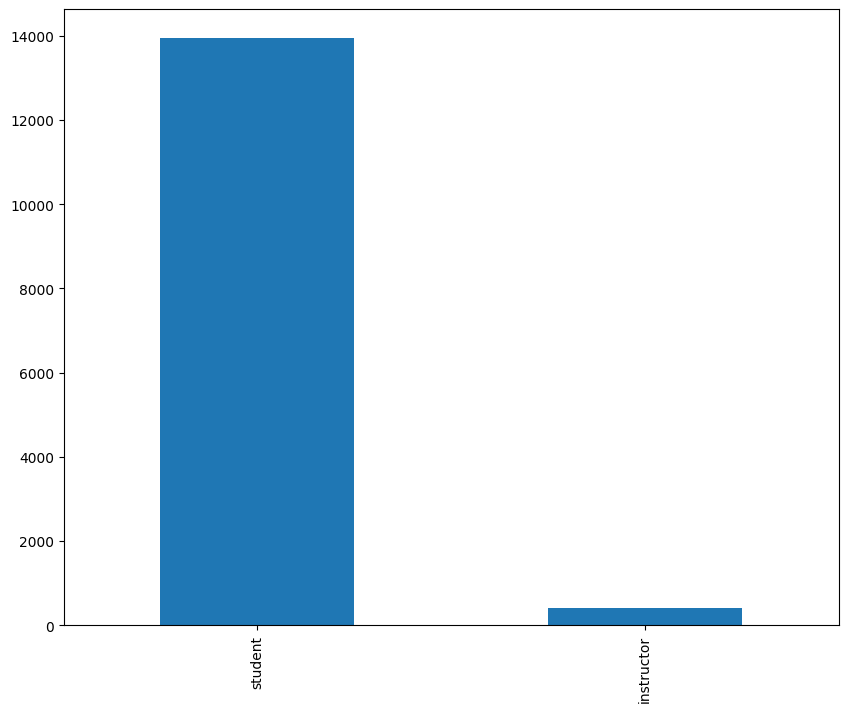

In [ ]:
posts["tag"].value_counts().plot(kind='bar')

This is an imbalanced dataset, need to figure out if there's anything I need to do in the preprocessing or feature extraction phase



imbalanced dataset -> stratified cross-validation; if not performing well, do downsampling and up weighting

In [ ]:
posts['content']=posts['content'].apply(str)

In [ ]:
posts['length'] = posts['content'].apply(len)

In [ ]:
print(posts.max(axis = 0))

tag                                                  student
content    “he the dealer then discards the lowest card a...
length                                                 28088
dtype: object


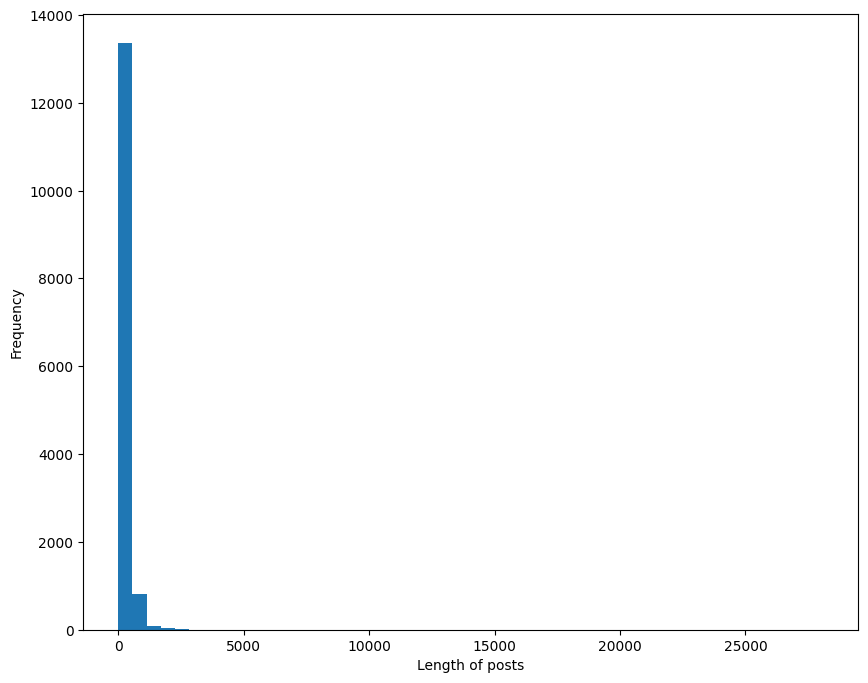

In [ ]:
posts['length'].plot.hist( bins=50)
plt.xlabel('Length of posts')
plt.rcParams['figure.figsize'] = [10, 8]
plt.show()

In [ ]:
posts.head()

,tag,content,length
0,instructor,project lab and exam grades are posted on ctoo...,52
1,instructor,project 2 students submitting 557 students wpe...,98
2,instructor,the resources found here cover many of the ess...,208
3,instructor,a quick message from vidal james p james j we ...,434
4,instructor,hi class if you stuck around until the veeeery...,459


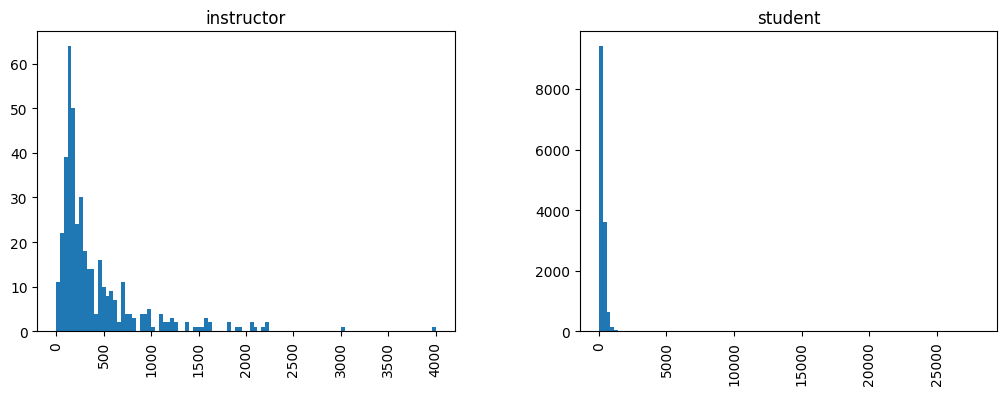

In [ ]:
posts.hist(column='length',by='tag', bins=100, figsize=(12,4))
plt.show()

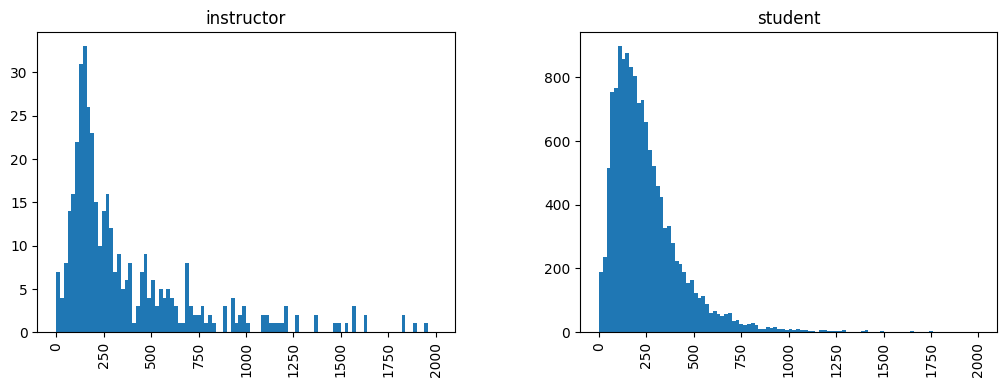

In [ ]:
posts.hist(column='length',by='tag', bins=100, range = [0,2000], figsize=(12,4))
plt.show()

it seems like the longer posts often come from instructors, though there are some rare, extremely long posts coming from students

In [ ]:
data_stu  = posts[posts['tag'] == "student"]
data_ins  = posts[posts['tag'] == "instructor"]

In [ ]:
type(data_stu)

pandas.core.frame.DataFrame

In [ ]:
def show_wordcloud(df, title):
  text = ' '.join(df['content'].astype(str).tolist())
  word_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS, max_font_size=50, background_color ="black",
                          colormap='Blues').generate(text)
  plt.figure(figsize=(16,10))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off') # not display axis
  plt.show()

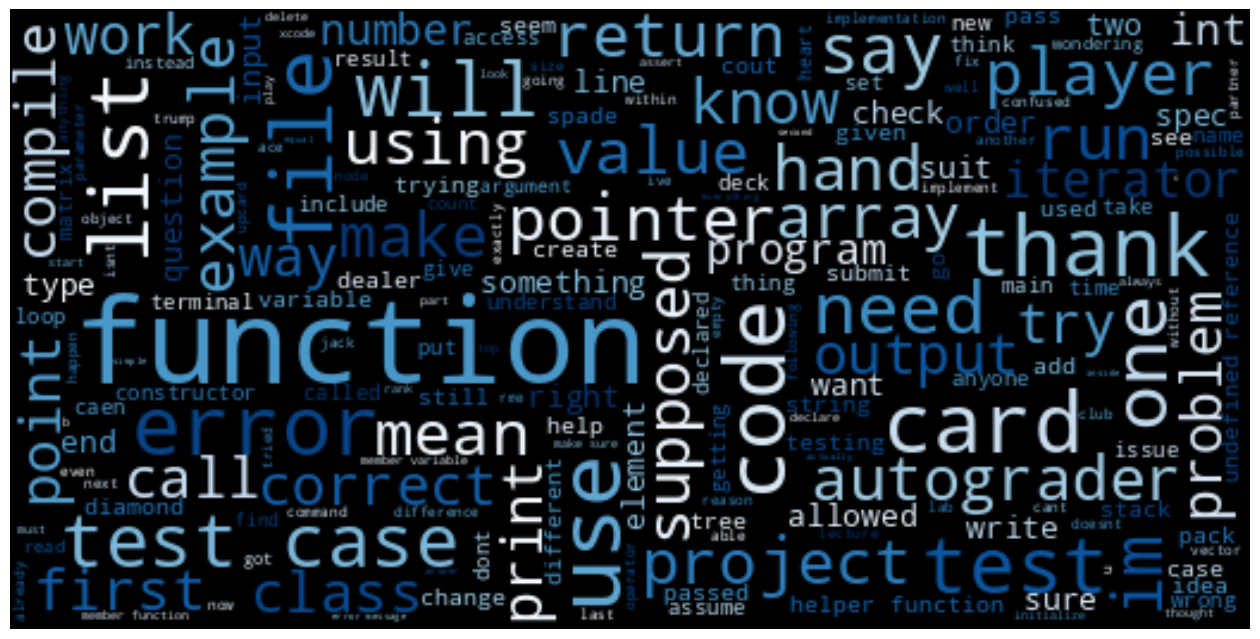

In [ ]:
show_wordcloud(data_stu, "Student posts")

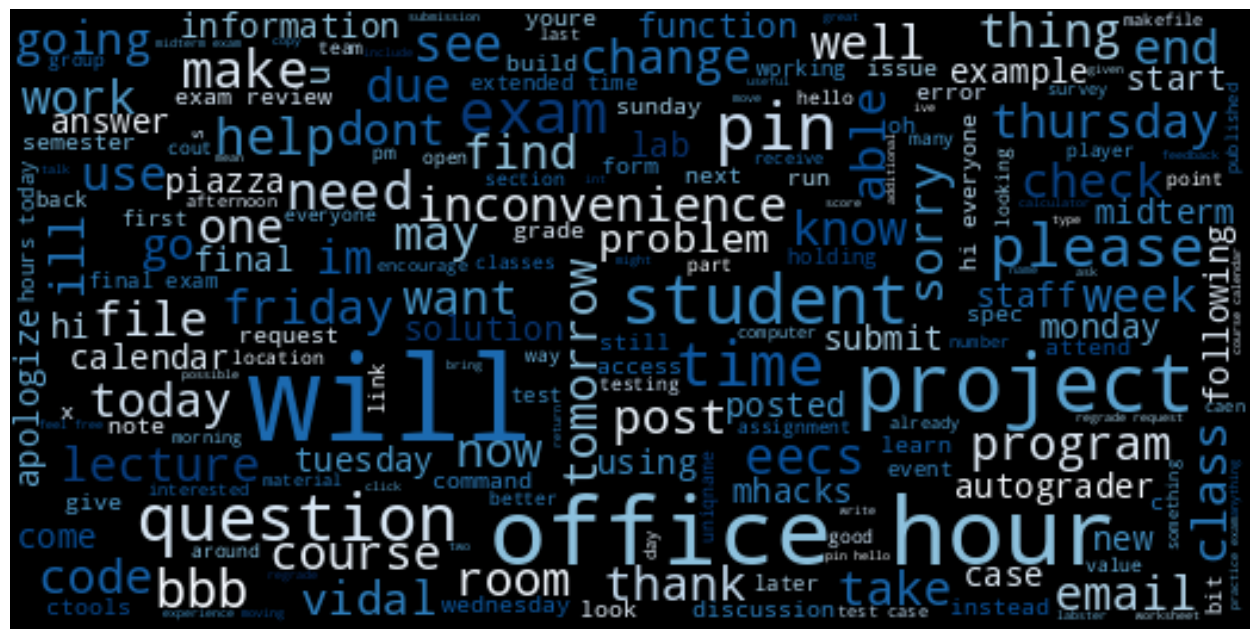

In [ ]:
show_wordcloud(data_ins, "Instructor posts")

below is the preprocessing phase

In [ ]:
posts['tag'] = posts['tag'].map( {'student': 1, 'instructor': 0})

mapping the classes from strings to numerical values

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def remove_stop_words(post):
  post_tokens = word_tokenize(post)
  #words = post.split()
  modified_words = [word for word in post_tokens if word not in stop_words]
  return ' '.join(modified_words)

In [ ]:
posts_processed = posts.copy()

In [ ]:
posts_processed['content'] = posts['content'].apply(remove_stop_words)

remove stop words in the posts; I made a copy of the dataframe and removed stop words in that because according to https://www.researchgate.net/publication/331961476_Study_on_the_Effect_of_Preprocessing_Methods_for_Spam_Email_Detection/fulltext/5c9520b945851506d7247000/Study-on-the-Effect-of-Preprocessing-Methods-for-Spam-Email-Detection.pdf, stemming, TF-iDF, and stop word removal gives better result for Naive Bayes model, but not for SVM. So I want to use both preprocessed and non-preprocessed data for different models

In [ ]:
ps = PorterStemmer()
posts_processed['content'] = posts_processed['content'].apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

In [ ]:
posts_processed['length'] = posts_processed['content'].apply(len)

did stemming on the content to get the root of each word, and recalculate the length of each post after stop words removal and stemming

In [ ]:
posts_processed.head()

,tag,content,length
0,0,project lab exam grade post ctool pin,37
1,0,project 2 student submit 557 student wperf sco...,90
2,0,resourc found cover mani essenti cours httpsdr...,146
3,0,quick messag vidal jame p jame j wish good luc...,283
4,0,hi class stuck around veeeeri end allnight rev...,288


In [ ]:
#content_df = posts_processed['content']

In [ ]:
##word_bag = []
#for content in content_df:
  #words = word_tokenize(content)
  #for w in words:
   # word_bag.append(w)
#word_bag = nltk.FreqDist(word_bag)

In [ ]:
#print('Number of words: {}'.format(len(word_bag)))


Number of words: 16001


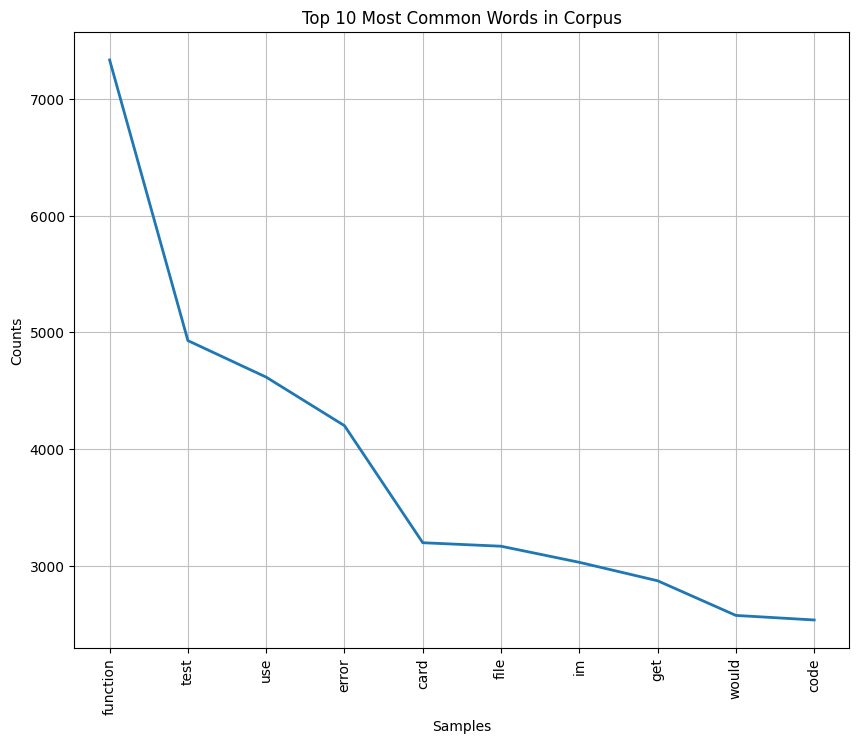

In [ ]:
#word_bag.plot(10, title='Top 10 Most Common Words in Corpus');


In [ ]:
tfidf = TfidfVectorizer()
tfidf_vector = tfidf.fit_transform(posts_processed)

In [ ]:
print(tfidf_vector)

  (0, 2)	1.0
  (1, 0)	1.0
  (2, 1)	1.0


In [ ]:
pipeline=Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

In [ ]:
#X = posts_processed.drop('tag', axis = 1)
X = posts_processed.content
y = posts_processed.tag
train_x, test_x, train_y, test_y =train_test_split(X, y, test_size = 0.3, random_state = 42)


In [ ]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(10047,)
(4306,)
(10047,)
(4306,)


In [ ]:
# Combine them back for resampling
train_data = pd.concat([train_x, train_y], axis=1)

In [ ]:
# Separate majority and minority classes
majority = train_data[train_data.tag==1]
minority = train_data[train_data.tag==0]

In [ ]:
train_data_under = resample(train_data[train_data.tag==1],
                replace=True,
                n_samples=train_data[train_data.tag==0].shape[0],
                random_state=123)

In [ ]:
x_train_under = train_data_under.content
y_train_under = train_data_under.tag

In [ ]:
#pipeline.fit(x_train_under, y_train_under)
pipeline.fit(train_x,train_y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [ ]:
pred=pipeline.predict(test_x)

In [ ]:
print(classification_report(test_y, pred))
print('-----------------------------------------')
print('Accuracy score: ',accuracy_score(test_y, pred))
print('-----------------------------------------')
print('Balanced Accuracy score: ',balanced_accuracy_score(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      0.05      0.09       126
           1       0.97      1.00      0.99      4180

    accuracy                           0.97      4306
   macro avg       0.99      0.52      0.54      4306
weighted avg       0.97      0.97      0.96      4306

-----------------------------------------
Accuracy score:  0.972131908964236
-----------------------------------------
Balanced Accuracy score:  0.5238095238095238
